<div style="border:solid grey 2px; padding: 20px">

# Megaline: plan comparison


# Project description

The goal of this project is to support decision making for the telecom operator Megaline.
The company offers its clients two prepaid plans, Surf and Ultimate. 
The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

Outline of analysis:
* Assessed the data and made decisions about outliers and skewed values.
* Performed clients profitability calculations and comparisons between groups of clients using Pandas and Numpy.
* Made recommendations backed by statistical inferences for the commercial department.

## Open the data file and study the general information:

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
from math import factorial
from scipy.stats import norm
from functools import reduce
import warnings
import random

calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")

warnings.simplefilter(action='ignore')

#### examine the data:

In [36]:
print("users")
print(users.info())
print("---------------------------------------")
print("plans")
print(plans.info())
print("---------------------------------------")
print("internet")
print(internet.info())
print("---------------------------------------")
print("calls")
print(calls.info())
print("---------------------------------------")
print("messages")
print(messages.info())

users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
---------------------------------------
plans
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        

In [37]:
print("users")
print(users.head(2))
print("---------------------------------------")
print("plans")
print(plans.head(2))
print("---------------------------------------")
print("internet")
print(internet.head(2))
print("---------------------------------------")
print("calls")
print(calls.head(2))
print("---------------------------------------")
print("messages")
print(messages.head(2))

users
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
---------------------------------------
plans
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  
---------------------------------------
internet
         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31    

* data is without duplicates and without nulls

## Prepare the data

* Convert the data to the necessary types.


* Find and eliminate errors in the data (Explain what errors you found and how you removed them). 

###### Note: many calls have a duration of 0.0 minutes. These might be missed calls. 
   
###### For each user, find:
* The **number of calls made** and minutes used per month.
* The number of text messages sent per month.
* The volume of data per month.
* The monthly revenue from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan).

#### Change dates to datetime: 

In [38]:
#change dates to datetime: 
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d') 
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d') 
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d') 
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d') 

#### group messages by 'user_id' & 'date':

In [39]:
#group messages by 'user_id' & 'date':
messages_count = messages.groupby(['user_id', 'message_date']).agg({'id': 'count'}).reset_index()
messages_count = messages_count.rename(columns = {'id':'number_of_messages','message_date':'date'})

#### study internet usage:

13.11% of internet usage equal to 0.


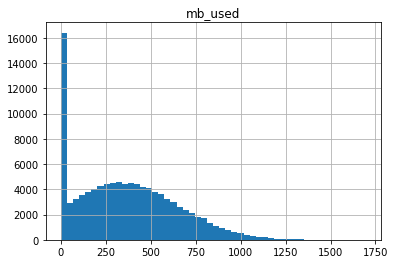

In [40]:
internet.hist('mb_used', bins=50);
empty_surf = round(len(internet.query('mb_used == 0').id)/len(internet.id)*100, 2)
print("{:}% of internet usage equal to 0.".format(empty_surf))

* There are 13.1% of values equal to zero. 
We are interested in summed up monthly internet usage, therefore it will not affect our analysis.

#### group internet usage by 'user_id' & 'date':

In [41]:
#group internet usage by 'user_id' & 'date':
internet_usage = internet.groupby(['user_id', 'session_date']).sum().reset_index()
internet_usage = internet_usage.rename(columns = {'session_date':'date'})

#### handle missed calles:

There are 19.48% missed calles.

Mean call duration with missed calles:      6.75
Mean call duration without missed calles:   8.38
difference of:                             24.15 %

std of call duration with missed calles:    5.84
std of call duration without missed calles: 5.35
difference of:                             -8.39 %


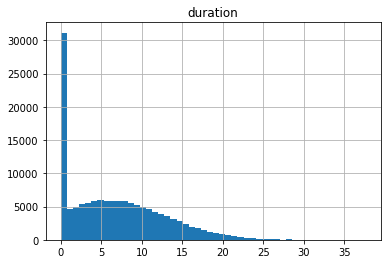

In [42]:
#handle missed calles:
calls.hist('duration', bins=50);
missed_calls = round(len(calls.query('duration == 0').id)/len(calls.id)*100, 2)

all_mean = calls.duration.mean().round(2)
all_std = calls.duration.std().round(2)
clear_mean = calls.query('duration > 0').duration.mean().round(2)
clear_std = calls.query('duration > 0').duration.std().round(2)

print("There are {:}% missed calles.".format(missed_calls))
print()
print("Mean call duration with missed calles:      {:}".format(all_mean))
print("Mean call duration without missed calles:   {:}".format(clear_mean))
print("difference of:                             {:} %".format(round((clear_mean/all_mean-1)*100,2)))
print()
print("std of call duration with missed calles:    {:}".format(all_std))
print("std of call duration without missed calles: {:}".format(clear_std))
print("difference of:                             {:} %".format(round((clear_std/all_std-1)*100,2)))

calls = calls.query('duration > 0')

* by droping the missed calles we improved the acurracy of our data.

#### group call duration by 'user_id' & 'date':

In [43]:
#group call duration by 'user_id' & 'date':
calls['call_duration_rounded'] = np.ceil(calls.duration)
calls_duration = calls.groupby(['user_id', 'call_date']).agg({'id': 'count','duration': 'sum' ,'call_duration_rounded': 'sum'}).reset_index()
calls_duration = calls_duration.rename(columns = {'id':'number_of_calls','duration':'calls_duration','call_date':'date'})

In [44]:
# check new dataframes:
print(messages_count.head(3))
print("---------------------------------------")
print(internet_usage.head(3))
print("---------------------------------------")
print(calls_duration.head(3))
print("---------------------------------------")

   user_id       date  number_of_messages
0     1000 2018-12-25                   1
1     1000 2018-12-26                   1
2     1000 2018-12-27                   3
---------------------------------------
   user_id       date  mb_used
0     1000 2018-12-26   270.99
1     1000 2018-12-27   880.22
2     1000 2018-12-28   660.40
---------------------------------------
   user_id       date  number_of_calls  calls_duration  call_duration_rounded
0     1000 2018-12-26                2           14.36                   15.0
1     1000 2018-12-27                5           48.26                   50.0
2     1000 2018-12-28                4           29.00                   31.0
---------------------------------------


#### merge internet, calls and messages by user id and date and ad month:

In [45]:
data_frames = [calls_duration, messages_count, internet_usage]
daily_data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'date'], how='outer'), data_frames)
daily_data['month'] = pd.DatetimeIndex(daily_data['date']).month
daily_data.head()

,user_id,date,number_of_calls,calls_duration,call_duration_rounded,number_of_messages,mb_used,month
0,1000,2018-12-26,2.0,14.36,15.0,1.0,270.99,12
1,1000,2018-12-27,5.0,48.26,50.0,3.0,880.22,12
2,1000,2018-12-28,4.0,29.00,31.0,1.0,660.40,12
3,1000,2018-12-29,1.0,1.70,2.0,1.0,89.86,12
4,1000,2018-12-30,1.0,4.22,5.0,1.0,NaN,12


#### creat monthly_data dataframe and add 'plan' column:

In [46]:
# creat monthly_data dataframe and add 'plan' column:
monthly_data = daily_data.groupby(['user_id', 'month']).sum().reset_index()

monthly_data['plan'] = False
for i in range(len(monthly_data)):
    userid = monthly_data.user_id.iloc[i]
    plan_i = str(users['plan'].loc[ users['user_id'] == userid ])
    
    if 'ultimate' in plan_i:
        monthly_data['plan'].iloc[i] = True
    else:
        monthly_data['plan'].iloc[i] = False
        
monthly_data.head()        

,user_id,month,number_of_calls,calls_duration,call_duration_rounded,number_of_messages,mb_used,plan
0,1000,12,16.0,116.83,124.0,11.0,1901.47,True
1,1001,8,22.0,171.14,182.0,30.0,6919.15,False
2,1001,9,38.0,297.69,315.0,44.0,13314.82,False
3,1001,10,47.0,374.11,393.0,53.0,22330.49,False
4,1001,11,49.0,404.59,426.0,36.0,18504.30,False


#### calculate monthly client payments:

,user_id,month,number_of_calls,calls_duration,call_duration_rounded,number_of_messages,mb_used,plan,monthly_payments
0,1000,12,16.0,116.83,124.0,11.0,1901.47,True,70.00
1,1001,8,22.0,171.14,182.0,30.0,6919.15,False,20.00
2,1001,9,38.0,297.69,315.0,44.0,13314.82,False,20.00
3,1001,10,47.0,374.11,393.0,53.0,22330.49,False,90.09
4,1001,11,49.0,404.59,426.0,36.0,18504.30,False,60.00


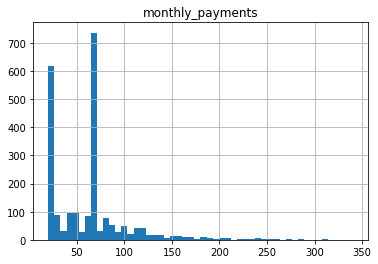

In [47]:
# calculate monthly client payments:
def monthly_pay(row, plan):
    payment = 0
    
    if row.plan:
        payment = plan.usd_monthly_pay[1]
        payment += np.where(row.call_duration_rounded > plan.minutes_included[1], (row.call_duration_rounded-plan.minutes_included[1])*plan.usd_per_minute[1], 0) 
        payment += np.where(row.number_of_messages > plan.messages_included[1], (row.number_of_messages -plan.messages_included[1])*plan.usd_per_message[1], 0) 
        payment += np.where(row.mb_used > plan.mb_per_month_included[1], np.ceil((row.mb_used - plan.mb_per_month_included[1])/1000)*plan.usd_per_gb[1], 0) 
            
    else:
        payment = plan.usd_monthly_pay[0]
        payment += np.where(row.call_duration_rounded > plan.minutes_included[0], (row.call_duration_rounded-plan.minutes_included[0])*plan.usd_per_minute[0], 0) 
        payment += np.where(row.number_of_messages > plan.messages_included[0], (row.number_of_messages -plan.messages_included[0])*plan.usd_per_message[0], 0) 
        payment += np.where(row.mb_used > plan.mb_per_month_included[0], np.ceil((row.mb_used - plan.mb_per_month_included[0])/1000)*plan.usd_per_gb[0], 0) 
  
    return payment

monthly_data['monthly_payments'] = monthly_data.apply( lambda row: monthly_pay(row , plans), axis=1)
monthly_data.query('monthly_payments <350').hist('monthly_payments', bins=50);
monthly_data.head()

* data is clear and ready to be worken on.

* we will focus on two main dataframes: 'users' and 'monthly_data'.

## Analyze the data
 
* Find the minutes, texts, and volume of data the users of each plan require per month. 
* Calculate the mean, dispersion, and standard deviation. 
* Plot histograms. 
* Describe the distributions.
* Describe the customers' behavior.

#### creat ultimate/surf plans dataframs:

In [48]:
#creat ultimate/surf plans dataframs.
monthly_ultimate = monthly_data[monthly_data.plan].reset_index()
monthly_surf = monthly_data[~monthly_data.plan].reset_index()

#### calls duration:

In [49]:
# minutes - describe the distributions and customers' behavior:
print("ultimate")
print("variance",round(monthly_ultimate.calls_duration.std()**2))
print(monthly_ultimate.calls_duration.describe())
print("-----------------------------------------------")
print("\nmonthly_surf")
print("variance",round(monthly_surf.calls_duration.std()**2))
print(monthly_surf.calls_duration.describe())

ultimate
variance 51641
count     720.000000
mean      406.193083
std       227.246499
min         0.000000
25%       246.290000
50%       398.585000
75%       532.227500
max      1292.090000
Name: calls_duration, dtype: float64
-----------------------------------------------

monthly_surf
variance 49135
count    1573.000000
mean      404.762390
std       221.664397
min         0.000000
25%       255.470000
50%       401.760000
75%       543.680000
max      1431.220000
Name: calls_duration, dtype: float64


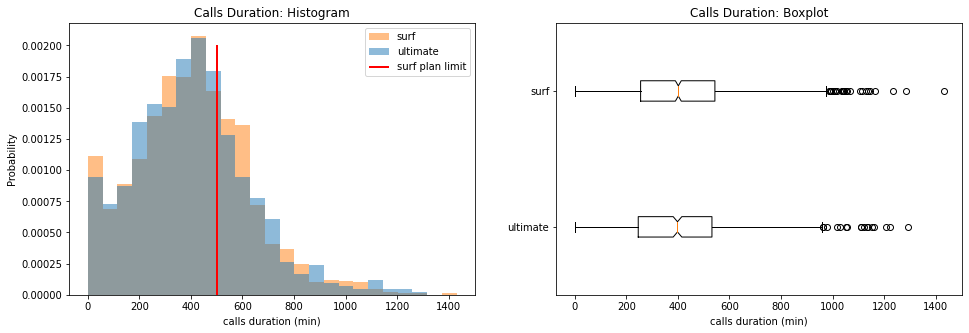

In [53]:
# plot calls duration
plt_calls_duration = [monthly_ultimate.calls_duration, monthly_surf.calls_duration]
fig, ax = plt.subplots(1,2,figsize=(16, 5))

ax[0].hist(plt_calls_duration, histtype='stepfilled', alpha=0.5, density=True, bins=25, label=['ultimate','surf'])
ax[0].vlines(x= plans.minutes_included[0], ymin=0, ymax=0.002, color = 'r', linewidth=2, label = 'surf plan limit')
ax[0].legend(prop={'size': 10})
ax[0].set_xlabel('calls duration (min)')
ax[0].set_ylabel('Probability')
ax[0].set_title('Calls Duration: Histogram')

ax[1].boxplot(plt_calls_duration, notch=True,vert=False, labels = ['ultimate','surf'])
ax[1].set_xlabel('calls duration (min)')
ax[1].set_title('Calls Duration: Boxplot')

plt.show()

* we can see there is no prominent diffrence in monthly calls duration between surf and ultimate users.
* the distrebution is looking normal.

#### number of text messages:

In [54]:
# text - describe the distributions and customers' behavior:
print("ultimate")
print("variance",round(monthly_ultimate.number_of_messages.std()**2))
print(monthly_ultimate.number_of_messages.describe())
print("-----------------------------------------------")
print("\nmonthly_surf")
print("variance",round(monthly_surf.number_of_messages.std()**2))
print(monthly_surf.number_of_messages.describe())
print("-----------------------------------------------")

messge_r_ultimate = round(100*len(monthly_ultimate.query('number_of_messages ==0').number_of_messages)/len(monthly_ultimate.number_of_messages),2)
messge_r_surf = round(100*len(monthly_surf.query('number_of_messages ==0').number_of_messages)/len(monthly_surf.number_of_messages),2)

print("\nprecent of 0 messages per month - ultimate: {:}%".format(messge_r_ultimate))
print("precent of 0 messages per month - surf:     {:}%".format(messge_r_surf))

ultimate
variance 1209
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: number_of_messages, dtype: float64
-----------------------------------------------

monthly_surf
variance 1127
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: number_of_messages, dtype: float64
-----------------------------------------------

precent of 0 messages per month - ultimate: 18.89%
precent of 0 messages per month - surf:     22.31%


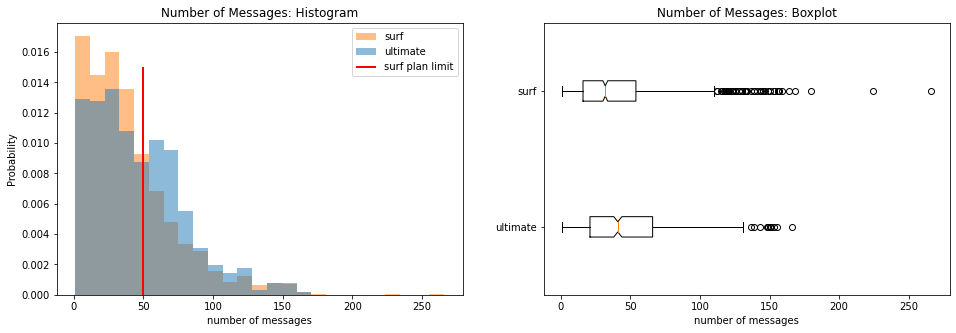

In [57]:
# plot number of text messages:
plt_messages = [monthly_ultimate.query('number_of_messages >0').number_of_messages, monthly_surf.query('number_of_messages >0').number_of_messages]
fig, ax1 = plt.subplots(1,2,figsize=(16, 5))

ax1[0].hist(plt_messages, histtype='stepfilled', alpha=0.5, density=True, bins=25, label=['ultimate','surf'])
ax1[0].vlines(x= plans.messages_included[0], ymin=0, ymax=0.015, color = 'r', linewidth=2, label = 'surf plan limit')
ax1[0].legend(prop={'size': 10})
ax1[0].set_xlabel('number of messages')
ax1[0].set_ylabel('Probability')
ax1[0].set_title('Number of Messages: Histogram')

ax1[1].boxplot(plt_messages, notch=True,vert=False, labels = ['ultimate','surf'])
ax1[1].set_xlabel('number of messages')
ax1[1].set_title('Number of Messages: Boxplot')

plt.show()

* overall ultimate plan users send more text messages.

- 1-50 messeges per month is more common with clients on the surf plan.
- my explanation is that the customers are aware to the 50 message limit and act accordingly.

- 51-100 messeges per month has greater representation of clients with the ultimate plan.

- Clients with the ultimate plan has 1000 messeges limit, the max masseges sent by ultimate is 166 and by surf is 266.
- 1000 messeges limit is no different than no limit at all for our clients.

#### internet data usage:

In [58]:
# data - describe the distributions and customers' behavior:
print("ultimate")
print("variance",round(monthly_ultimate.mb_used.std()**2))
print(monthly_ultimate.mb_used.describe())
print("-----------------------------------------------")
print("\nmonthly_surf")
print("variance",round(monthly_surf.mb_used.std()**2))
print(monthly_surf.mb_used.describe())

ultimate
variance 61652293
count      720.000000
mean     17214.699694
std       7851.897435
min          0.000000
25%      12666.955000
50%      16858.340000
75%      21014.527500
max      46595.330000
Name: mb_used, dtype: float64
-----------------------------------------------

monthly_surf
variance 64216396
count     1573.000000
mean     16558.283490
std       8013.513327
min          0.000000
25%      11986.520000
50%      16829.310000
75%      20999.610000
max      70931.590000
Name: mb_used, dtype: float64


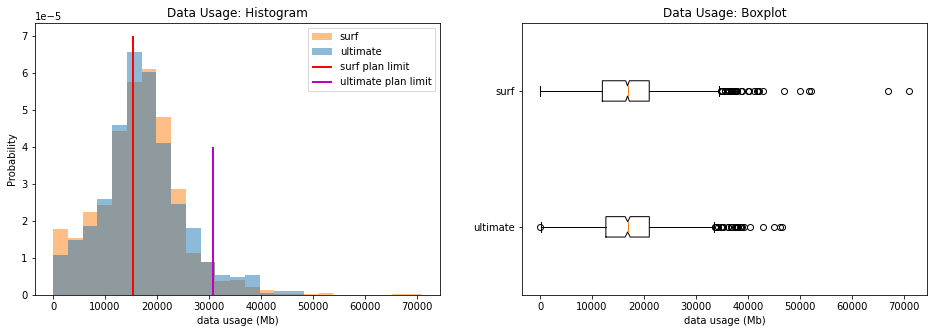

In [60]:
# plot internet data usage:
plt_data = [monthly_ultimate.mb_used, monthly_surf.mb_used]
fig, ax2 = plt.subplots(1,2,figsize=(16, 5))

ax2[0].hist(plt_data, histtype='stepfilled', alpha=0.5, density=True, bins=25, label=['ultimate','surf'])
ax2[0].vlines(x= plans.mb_per_month_included[0], ymin=0, ymax=0.00007, color = 'r', linewidth=2, label = 'surf plan limit')
ax2[0].vlines(x= plans.mb_per_month_included[1], ymin=0, ymax=0.00004, color = 'm', linewidth=2, label = 'ultimate plan limit')
ax2[0].legend(prop={'size': 10})
ax2[0].set_xlabel('data usage (Mb)')
ax2[0].set_ylabel('Probability')
ax2[0].set_title('Data Usage: Histogram')

ax2[1].boxplot(plt_data, notch=True,vert=False, labels = ['ultimate','surf'])
ax2[1].set_xlabel('data usage (Mb)')
ax2[1].set_title('Data Usage: Boxplot')

plt.show()

* we can see there is no prominent diffrence in monthly data usage duration between surf and ultimate users.
* the distrebution is looking normal.

## Test the hypotheses
* The average revenue from users of Ultimate and Surf calling plans differs.
* The average revenue from users in NY-NJ area is different from that of the users from other regions.
* You decide what alpha value to use.

###### Explain:
* How you formulated the null and alternative hypotheses.
* What criterion you used to test the hypotheses and why.

#### revenue by plans:

In [61]:
# revenue - describe the distributions and customers' behavior:
print("ultimate")
print("variance",round(monthly_ultimate.monthly_payments.std()**2))
print(monthly_ultimate.monthly_payments.describe())
print("-----------------------------------------------")
print("\nmonthly_surf")
print("variance",round(monthly_surf.monthly_payments.std()**2))
print(monthly_surf.monthly_payments.describe())

var_ratio = round((monthly_surf.monthly_payments.std()/monthly_ultimate.monthly_payments.std())**2, 2 )
print("\nsurf/ultimate variance ratio:", var_ratio)

ultimate
variance 138
count    720.000000
mean      72.381944
std       11.731937
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: monthly_payments, dtype: float64
-----------------------------------------------

monthly_surf
variance 3199
count    1573.000000
mean       61.431138
std        56.556853
min        20.000000
25%        20.000000
50%        40.510000
75%        81.950000
max       600.370000
Name: monthly_payments, dtype: float64

surf/ultimate variance ratio: 23.24


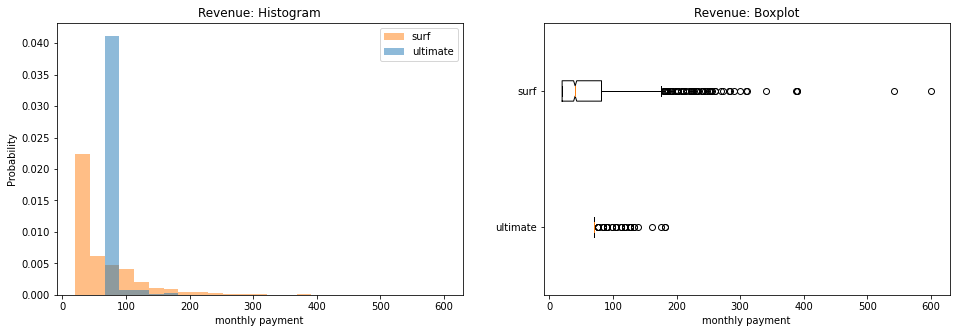

In [64]:
# plot revenue:
plt_revenue = [monthly_ultimate.monthly_payments, monthly_surf.monthly_payments]
fig, ax3 = plt.subplots(1,2,figsize=(16, 5))

ax3[0].hist(plt_revenue, histtype='stepfilled', alpha=0.5, density=True, bins=25, label=['ultimate','surf'])
ax3[0].legend(prop={'size': 10})
ax3[0].set_xlabel('monthly payment')
ax3[0].set_ylabel('Probability')
ax3[0].set_title('Revenue: Histogram')

ax3[1].boxplot(plt_revenue, notch=True,vert=False, labels = ['ultimate','surf'])
ax3[1].set_xlabel('monthly payment')
ax3[1].set_title('Revenue: Boxplot')

plt.show()

* the average monthly payment of ultimate clients is: 72.38.
* which is very close to the package's base price of 70.

* the average monthly payment of surf clients is: 61.43.
* which is much higher than the package base price of 20.

* there is big difference in the monthly payment distrebution between ultimate and surf clients.
* the scale of the difference can be seen in the std and the variance of the two groups.

#### revenue by plans formulated null hypothesis:

* The formulated null hypothesis is: Average revenue from of Ultimate and average revenue from Surf calling plans are equal.

* The alternative hypothesis is: Average revenue from of Ultimate and average revenue from Surf calling plans are not equal.

In [65]:
#null hypothesis - average revenue from users of Ultimate and Surf calling plans are equal. 
alpha = 0.01  
results = st.ttest_ind(monthly_ultimate.monthly_payments, monthly_surf.monthly_payments)
print('alpha:   ', alpha  )
print('p-value: ', results.pvalue  )

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

alpha:    0.01
p-value:  2.9100643067905846e-07
We reject the null hypothesis


* We rejected the null hypothesis that average revenue from users of Ultimate and Surf calling plans is equal.

#### creat dataframe for users in NY-NJ area and for the users from other regions:

In [66]:
#creat dataframe for users in NY-NJ area and for the users from other regions:
users['area'] = ""
users['state'] = ""
for i in range(len(users)):
    users['area'].iloc[i] , users['state'].iloc[i] = users.city.iloc[i].split(",")

users_state = users[['user_id', 'state']]   
monthly_data_2 = pd.merge(left = monthly_data , right = users_state, how='left',on='user_id')

NJ_NY_monthly = monthly_data_2[monthly_data_2['state'].str.contains("NJ"or"NY")]

not_NJ_NY_monthly = monthly_data_2.drop(index = NJ_NY_monthly.index, axis=1).reset_index()
NJ_NY_monthly = NJ_NY_monthly.reset_index()

#### IS the average revenue from users in NY-NJ area is different from that of the users from other regions?

In [67]:
# IS the average revenue from users in NY-NJ area is different from that of the users from other regions?
print("NJ-NY monthly payments:")
print("variance",round(NJ_NY_monthly.monthly_payments.std()**2))
print(NJ_NY_monthly.monthly_payments.describe())
print("-----------------------------------------------")
print("\nnot NJ-NY monthly payments:")
print("variance",round(not_NJ_NY_monthly.monthly_payments.std()**2))
print(not_NJ_NY_monthly.monthly_payments.describe())

NJ-NY monthly payments:
variance 2105
count    459.000000
mean      61.148824
std       45.878945
min       20.000000
25%       20.000000
50%       55.490000
75%       71.320000
max      290.000000
Name: monthly_payments, dtype: float64
-----------------------------------------------

not NJ-NY monthly payments:
variance 2299
count    1834.000000
mean       65.800911
std        47.950552
min        20.000000
25%        26.442500
50%        70.000000
75%        70.000000
max       600.370000
Name: monthly_payments, dtype: float64


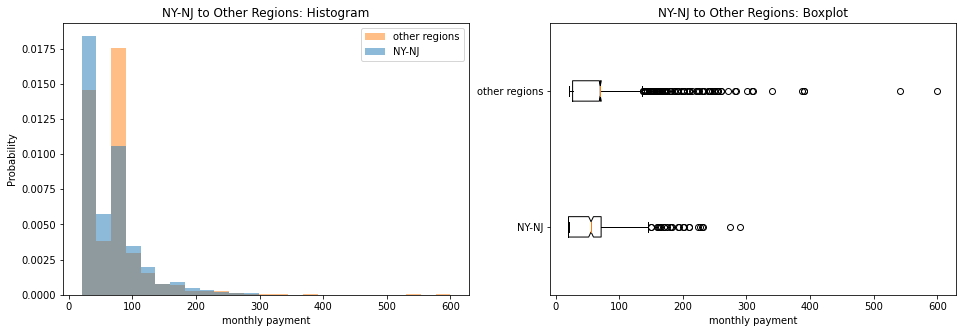

In [70]:
# NY-NJ area revenue comparison:
plt_NY_NJ = [NJ_NY_monthly.monthly_payments, not_NJ_NY_monthly.monthly_payments]
fig, ax4 = plt.subplots(1,2,figsize=(16, 5))

ax4[0].hist(plt_NY_NJ, histtype='stepfilled', alpha=0.5, density=True, bins=25, label=['NY-NJ','other regions'])
ax4[0].legend(prop={'size': 10})
ax4[0].set_xlabel('monthly payment')
ax4[0].set_ylabel('Probability')
ax4[0].set_title('NY-NJ to Other Regions: Histogram')

ax4[1].boxplot(plt_NY_NJ, notch=True,vert=False, labels = ['NY-NJ','other regions'])
ax4[1].set_xlabel('monthly payment')
ax4[1].set_title('NY-NJ to Other Regions: Boxplot')

plt.show()

In [71]:
print("ultimate plan percentage in NY-NJ is:     ", round(100*NJ_NY_monthly.plan.mean(),2),"%" )
print("ultimate plan percentage not in NY-NJ is: ", round(100*not_NJ_NY_monthly.plan.mean(),2),"%" )
NY_NJ_plans_ratio = round(100*((not_NJ_NY_monthly.plan.mean() - NJ_NY_monthly.plan.mean() )/NJ_NY_monthly.plan.mean()),1)
print("users outside of NY-NJ area are {:}% more likly having an ultimate plan.".format(NY_NJ_plans_ratio))

ultimate plan percentage in NY-NJ is:      21.13 %
ultimate plan percentage not in NY-NJ is:  33.97 %
users outside of NY-NJ area are 60.7% more likly having an ultimate plan.


#### revenue by rigion formulated null hypothesis:

* The formulated null hypothesis is: Average revenue from NJ-NY users and average revenue not from NJ-NY are equal.

* The alternative hypothesis is: Average revenue from NJ-NY users and average revenue not from NJ-NY are not equal.

In [72]:
#null hypothesis - average revenue from users from NJ-NY and users not from NJ-NY calling plans are equal. 

alpha = 0.05  
results = st.ttest_ind(not_NJ_NY_monthly.monthly_payments, NJ_NY_monthly.monthly_payments)
print('alpha:   ', alpha)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis") 

alpha:    0.05
p-value:  0.060944683763950805
We can't reject the null hypothesis


* I have chosen alpha = 0.05. 
* the p-value is close enoth to the alpha that we can further study this case with editional data and parameters.

## Overall conclusion

In [73]:
print("")
print("Precent of users that pay extra fees by plan:")
print("Ultimate: ",round(100*(1-len(monthly_ultimate.query('monthly_payments == 70'))/len(monthly_ultimate)),2),"%")
print("Surf:     ",round(100*(1-len(monthly_surf.query('monthly_payments == 50'))/len(monthly_surf)),2),"%")
print("")
print("Precent of users that pay extra fees for calls duration:")
print("Ultimate: ",round(100*(len(monthly_ultimate.query('calls_duration >= 3000'))/len(monthly_ultimate)),2),"%")
print("Surf:     ",round(100*(len(monthly_surf.query('calls_duration >= 500'))/len(monthly_surf)),2),"%")
print("")
print("Precent of users that pay extra fees for messages:")
print("Ultimate: ",round(100*(len(monthly_ultimate.query('number_of_messages >= 1000'))/len(monthly_ultimate)),2),"%")
print("Surf:     ",round(100*(len(monthly_surf.query('number_of_messages >= 50'))/len(monthly_surf)),2),"%")
print("")
print("Precent of users that pay extra fees for Mb used:")
print("Ultimate: ",round(100*(len(monthly_ultimate.query('mb_used >= 30720'))/len(monthly_ultimate)),2),"%")
print("Surf:     ",round(100*(len(monthly_surf.query('mb_used >= 15360'))/len(monthly_surf)),2),"%")
print("--------------------------------------------------------")
print("")

mean_dif = 100*round(monthly_ultimate.monthly_payments.mean()/monthly_surf.monthly_payments.mean()-1,4)
print("Users on the Ultimate plan are on average {:}% more profitable than Surf users.\n".format(mean_dif))
print("--------------------------------------------------------")
print("")

data_usage_treshhold = int(round(plans.mb_per_month_included[0]/1000) + ((plans.usd_monthly_pay[1]-plans.usd_monthly_pay[0])/plans.usd_per_gb[0]))
print("Ultimate users with data usage greater than {:} Gb are more profitable as Surf users.\n".format(data_usage_treshhold))



Precent of users that pay extra fees by plan:
Ultimate:  5.69 %
Surf:      97.01 %

Precent of users that pay extra fees for calls duration:
Ultimate:  0.0 %
Surf:      30.77 %

Precent of users that pay extra fees for messages:
Ultimate:  0.0 %
Surf:      22.5 %

Precent of users that pay extra fees for Mb used:
Ultimate:  5.69 %
Surf:      57.91 %
--------------------------------------------------------

Users on the Ultimate plan are on average 17.83% more profitable than Surf users.

--------------------------------------------------------

Ultimate users with data usage greater than 20 Gb are more profitable as Surf users.



* Average revenue of the Surf plan is different from average revenue of the Ultimate plan with confidence level higher than 99%.

* There is large difference in income variance between surf and ultimate users, surf/ultimate variance ratio is 23.24.

* The difference in payment variance is comming from the extra fees of the plans.

* Most of the ultimate users( 94.3%) pay the package base price of 70 dollars.

* While the surf users pay much more fees and are more profitable to us as a company.

* Most of the extra fees are comming from data usage.

* Customers from NJ-NY area do not have distinct expenditure profile to customers in other rigions.

* the reason is that users outside of NY-NJ area are 60.7% more likly having an ultimate plan.
 
##### recommendations: 
* We can try convince ultimate with data usage greater than 20 Gb to change plans to surf.
* As well as try and make the 27.4% of surf users that are not going over the plans limit to change to ultimate.
